In [5]:
import numpy as np
import matplotlib.pyplot as plt
from TidalPy import __version__
from TidalPy.RadialSolver import radial_solver
from TidalPy.utilities.graphics.multilayer import yplot
from TidalPy.rheology.models import Maxwell, Andrade, Elastic
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays

print(__version__)
run_times = True


0.6.0a8.dev9


## 1 Layer

Result Success: True
Result Message: RadialSolver.ShootingMethod:: completed without any noted issues.

RadialSolver
638 μs ± 7.27 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Shape: (6, 25).


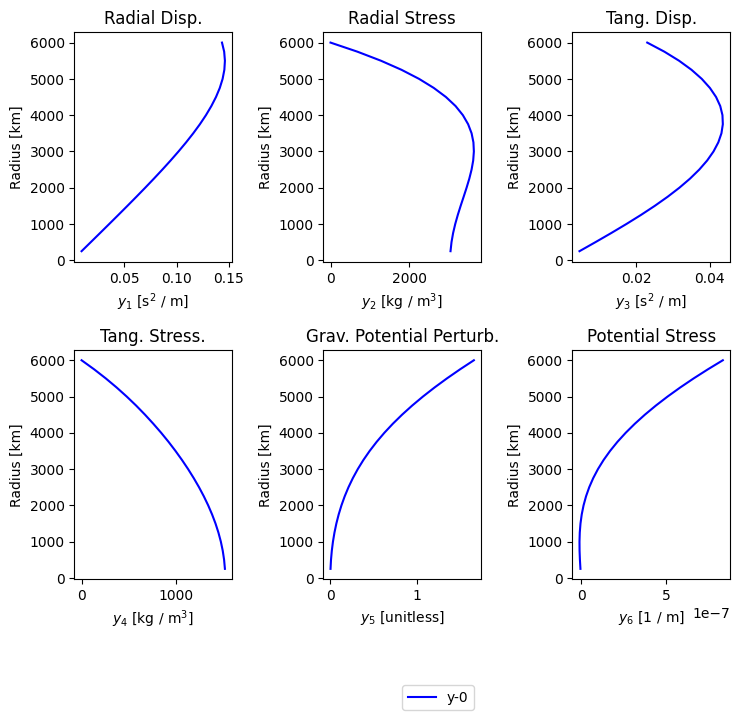

Steps Required:
[[52 48 39]]
[0.65847836-0.03056431j 1.29915876-0.06226479j 0.20796602-0.00491235j]
EOS Steps: [[16]
 [16]]


In [19]:
def test_1layer():
    frequency = np.pi * 2. / (86400. * 7.5)
    
    radius_array = np.linspace(0., 6000.0e3, 25)
    density_array = np.ones_like(radius_array) * 5400.
    planet_bulk_density = np.average(density_array)
    shear_array = np.ones_like(radius_array) * 50.0e9
    viscosity_array = np.ones_like(radius_array) * 1.0e18

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)

    complex_bulk_modulus_array = np.ones(radius_array.shape, dtype=np.complex128) * (1.0e11 + 0.0j)
    
    input_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        complex_bulk_modulus_array=complex_bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=('solid',),
        is_static_bylayer=(False,),
        is_incompressible_bylayer=(False,),
        upper_radius_bylayer_array=np.asarray([radius_array[-1]]),
        surface_pressure = 0.0,
        degree_l = 2,
        solve_for = None,
        core_condition = 0,
        use_kamata = True,
        starting_radius = 0.1,
        start_radius_tolerance = 1.0e-5,
        integration_method = 'DOP853',
        integration_rtol = 1.0e-3,
        integration_atol = 1.0e-4,
        scale_rtols_bylayer_type = False,
        max_num_steps = 500_000,
        expected_size = 200,
        max_ram_MB = 500,
        max_step = 0,
        nondimensionalize = True,
        use_prop_matrix = False,
        verbose = False,
        warnings = False,
        raise_on_fail = False,
        eos_method_bylayer = None,
        eos_integration_method = 'RK45',
        eos_rtol = 1.0e-4,
        eos_atol = 1.0e-8,
        eos_pressure_tol = 1.0e-2,
        eos_max_iters = 50,
        perform_checks = False
    )

    solution = radial_solver(**input_dict)
    
    print("Result Success:", solution.success)
    print("Result Message:", solution.message)
    
    if run_times:
        %timeit radial_solver(**input_dict)

    ys = solution.result

    print(f'Shape: {ys.shape}.')
    yplot([ys], [radius_array], colors=['b'])

    print("Steps Required:")
    print(solution.steps_taken)

    print(solution.love)
    print('EOS Steps:', solution.eos_steps_taken)

    return solution

# 0.5.4
#   New: 3.12ms; 3.07ms; 3.15ms
#   Old: 94ms; 96.6ms; 94.3ms
# 0.6.0a0
#   New: 3.37ms; 3.14ms; 3.16ms
#   Old: 94ms; 92.6ms; 92.4ms
# 0.6.0a6
#   New: 3.37ms; 3.14ms; 3.16ms
# 0.6.0a8
#   Apples to Apples: 3.85ms; 3.86ms; 4.0ms
#   Using Better tolerances: 
#     0.631ms; 0.628ms; 0.638ms

solution = test_1layer()

# 2 Layers

679 μs ± 6.21 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Result Success: True
Result Message: RadialSolver.ShootingMethod:: completed without any noted issues.



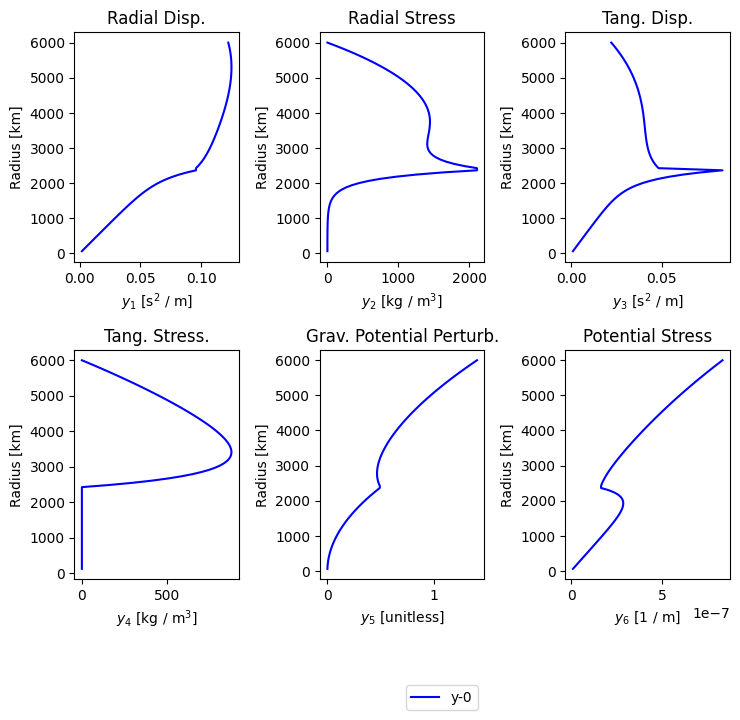

Steps Required:
[[33 58  0]
 [ 6  6  8]]
[0.40709477-0.00763563j 0.81741461-0.01480226j 0.14765935-0.00325735j]
EOS Steps: [[22  5]
 [22  5]
 [22  5]]


In [29]:
def test_2layer():
    layer_types = ('liquid', 'solid')
    is_static_by_layer = (False, False)
    integration_method = 'DOP853'
    integration_rtol = 1.0e-4
    integration_atol = 1.0e-6
    nondimensionalize = True
    is_incompressible_by_layer = (False, False)
    use_kamata = False
    
    radius_array = np.linspace(0.0, 6000.0e3, 100)
    CMB_radius = 0.4 * radius_array[-1]
    upper_radius_by_layer = np.asarray((CMB_radius, radius_array[-1]))
    
    frequency = np.pi * 2. / (86400. * 0.3)
    
    ic_index = radius_array <= CMB_radius
    mantle_index = radius_array > CMB_radius
    
    indices_by_layer = (ic_index, mantle_index)
    complex_bulk_modulus_array = np.ones(radius_array.shape, dtype=np.complex128) * (1.0e11 + 0.0j)
    
    density_array = np.ones_like(radius_array) * 3500.
    density_array[ic_index] = 11000.
    planet_bulk_density = np.average(density_array)
    complex_bulk_modulus_array[ic_index] = 5.0e11 + 0.0j
    shear_array = np.ones_like(radius_array) * 50.0e9
    shear_array[ic_index] = 0.
    viscosity_array = np.ones_like(radius_array) * 1.0e18
    viscosity_array[ic_index] = 1000.

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)

    input_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        complex_bulk_modulus_array=complex_bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=layer_types,
        is_static_bylayer=is_static_by_layer,
        is_incompressible_bylayer=is_incompressible_by_layer,
        upper_radius_bylayer_array=upper_radius_by_layer,
        surface_pressure = 0.0,
        degree_l = 2,
        solve_for = None,
        core_condition = 0,
        use_kamata = use_kamata,
        starting_radius = 1.0e4,
        start_radius_tolerance = 1.0e-5,
        integration_method = integration_method,
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        scale_rtols_bylayer_type = False,
        max_num_steps = 50_000_000,
        expected_size = 250,
        max_ram_MB = 4500,
        max_step = 0,
        nondimensionalize = nondimensionalize,
        use_prop_matrix = False,
        verbose = False,
        warnings = False,
        raise_on_fail = False,
        eos_method_bylayer = None,
        eos_integration_method = 'RK45',
        eos_rtol = 1.0e-4,
        eos_atol = 1.0e-12,
        eos_pressure_tol = 1.0e-2,
        eos_max_iters = 50,
        perform_checks = False
    )

    solution = radial_solver(**input_dict)
    
    if run_times:
        %timeit radial_solver(**input_dict)

    ys = solution.result
    print("Result Success:", solution.success)
    print("Result Message:", solution.message)
    
    yplot([ys], [radius_array], colors=['b'])

    print("Steps Required:")
    print(solution.steps_taken)

    print(solution.love)
    print('EOS Steps:', solution.eos_steps_taken)


# 0.5.3
#   3.06ms; 3.08ms
# 0.5.4
#   New: 2.39ms; 2.42ms; 2.43ms
#   Old: 99.4ms; 97.7ms; 100ms
# 0.6.0
#   New: 2.38ms; 2.41ms; 2.38ms
#   Old: 100ms; 97.8ms; 95.8ms
# 0.6.0a8
#   Apples to Apples: 3.41ms; 3.29ms; 3.28ms
#   Using Better tolerances: 
#     0.680ms; 0.690ms; 0.679ms



test_2layer()

## 3 Layers

654 μs ± 22.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Result Success: True
Result Message: RadialSolver.ShootingMethod:: completed without any noted issues.



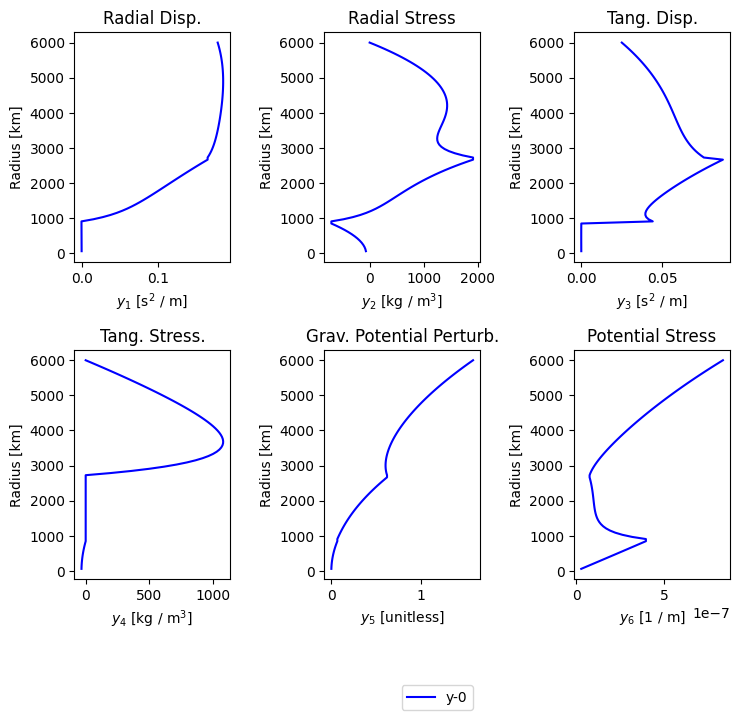

Steps Required:
[[17 19 13]
 [ 6  5  0]
 [ 5  5  7]]
[0.58344663-0.00977677j 1.1631217 -0.01887378j 0.16450088-0.00284561j]
EOS Steps: [[20  5  4]
 [20  5  4]
 [20  5  4]]


In [41]:
def test_3layer():
    layer_types = ('solid', 'liquid', 'solid')
    is_static_by_layer = (False, False, False)
    integration_method = 'DOP853'
    integration_rtol = 1.0e-4
    integration_atol = 1.0e-6
    nondimensionalize = True
    is_incompressible_by_layer = (False, False, False)
    use_kamata = False
    
    radius_array = np.linspace(0.0, 6000.0e3, 100)
    ICB_radius = 0.15 * radius_array[-1]
    CMB_radius = 0.45 * radius_array[-1]
    upper_radius_by_layer = np.asarray((ICB_radius, CMB_radius, radius_array[-1]))
    
    frequency = np.pi * 2. / (86400. * 0.1)
    
    ic_index = radius_array <= ICB_radius
    oc_index = np.logical_and(radius_array > ICB_radius, radius_array <= CMB_radius)
    mantle_index = radius_array > CMB_radius
    
    indices_by_layer = (ic_index, oc_index, mantle_index)
    density_array = np.ones_like(radius_array) * 3500.
    density_array[ic_index] = 9600.
    density_array[oc_index] = 8000.
    
    planet_bulk_density = np.average(density_array)
    
    complex_bulk_modulus_array = np.ones(radius_array.shape, dtype=np.complex128) * (1.0e11 + 0.0j)
    complex_bulk_modulus_array[ic_index] = (10.0e11 + 0.0j)
    complex_bulk_modulus_array[oc_index] = (5.0e11 + 0.0j)
    shear_array = np.ones_like(radius_array) * 50.0e9
    shear_array[ic_index] = 150.0e9
    shear_array[oc_index] = 0.
    viscosity_array = np.ones_like(radius_array) * 1.0e18
    viscosity_array[ic_index] = 1.0e27
    viscosity_array[oc_index] = 1000.

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)

    input_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        complex_bulk_modulus_array=complex_bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=layer_types,
        is_static_bylayer=is_static_by_layer,
        is_incompressible_bylayer=is_incompressible_by_layer,
        upper_radius_bylayer_array=upper_radius_by_layer,
        surface_pressure = 0.0,
        degree_l = 2,
        solve_for = None,
        core_condition = 0,
        use_kamata = use_kamata,
        starting_radius = 0.1,
        start_radius_tolerance = 1.0e-5,
        integration_method = integration_method,
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        scale_rtols_bylayer_type = False,
        max_num_steps = 100_000,
        expected_size = 150,
        max_ram_MB = 500,
        max_step = 0,
        nondimensionalize = nondimensionalize,
        use_prop_matrix = False,
        verbose = False,
        warnings = False,
        raise_on_fail = False,
        eos_method_bylayer = None,
        eos_integration_method = 'RK45',
        eos_rtol = 1.0e-4,
        eos_atol = 1.0e-12,
        eos_pressure_tol = 1.0e-2,
        eos_max_iters = 50,
        perform_checks = True
    )

    solution = radial_solver(**input_dict)
    
    if run_times:
        %timeit radial_solver(**input_dict)

    ys = solution.result
    print("Result Success:", solution.success)
    print("Result Message:", solution.message)
    
    yplot([ys], [radius_array], colors=['b'])

    print("Steps Required:")
    print(solution.steps_taken)

    print(solution.love)
    print('EOS Steps:', solution.eos_steps_taken)

    
# 0.5.4
# New: 1.54ms; 1.53ms; 1.55ms
# Old: 112ms; 114ms; 116ms
# 0.6.0a8
#   Apples to Apples: 1.24ms; 1.23ms; 1.23ms
#   Using Better tolerances: 
#     0.625ms; 0.665ms; 0.654ms

test_3layer()

## 4 Layers (Low Density Liquid)

1.21 ms ± 37.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Result Success: True
Result Message: RadialSolver.ShootingMethod:: completed without any noted issues.



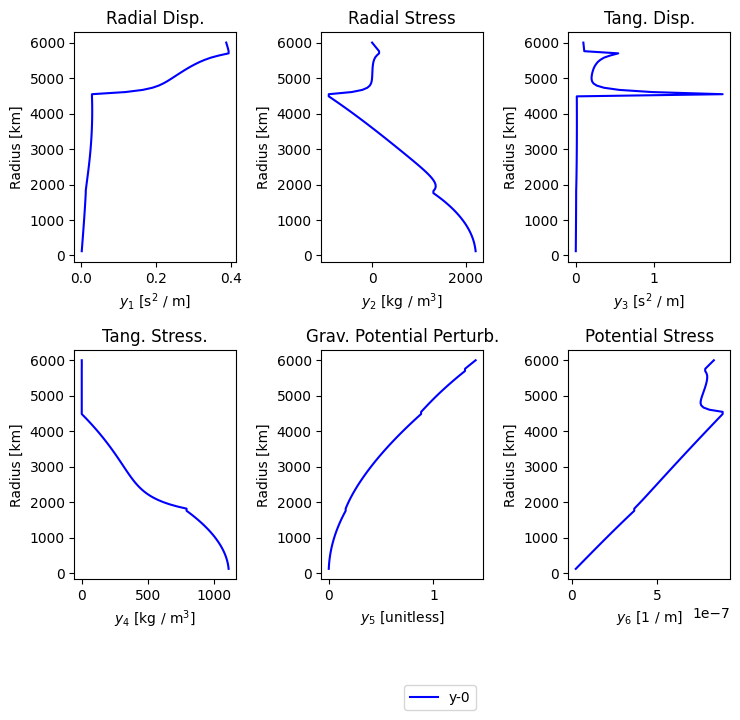

Steps Required:
[[26 29 23]
 [10 13 14]
 [16 18  0]
 [13 13  7]]
[0.40257566-0.00220938j 1.43079096-0.00622687j 0.36210686+0.00223547j]
EOS Steps: [[21  5  4  4]
 [21  5  4  4]
 [21  5  4  4]]


In [56]:
def test_4layer():
    layer_types = ('solid', 'solid', 'liquid', 'solid')
    is_static_by_layer = (False, False, False, False)
    integration_method = 'DOP853'
    integration_rtol = 1.0e-8
    integration_atol = 1.0e-12
    nondimensionalize = True
    is_incompressible_by_layer = (False, False, False, False)
    use_kamata = False
    
    radius_array = np.linspace(0.0, 6000.0e3, 100)
    CMB_radius = 0.3 * radius_array[-1]
    ocean_radius = 0.75 * radius_array[-1]
    ice_radius = 0.95 * radius_array[-1]
    upper_radius_by_layer = np.asarray((CMB_radius, ocean_radius, ice_radius, radius_array[-1]))
    
    frequency = np.pi * 2. / (86400. * 0.5)
    
    ic_index = radius_array <= CMB_radius
    mantle_index = np.logical_and(radius_array > CMB_radius, radius_array <= ocean_radius)
    ocean_index = np.logical_and(radius_array > ocean_radius, radius_array <= ice_radius)
    ice_index = radius_array > ice_radius
    
    indices_by_layer = (ic_index, mantle_index, ocean_index, ice_index)
    density_array = np.ones_like(radius_array) * 3500.
    density_array[ic_index] = 9600.
    density_array[ocean_index] = 1000.
    density_array[ice_index] = 920.
    
    planet_bulk_density = np.average(density_array)
    
    complex_bulk_modulus_array = np.ones(radius_array.size, dtype=np.complex128) * (1.0e11 + 0.0j)
    complex_bulk_modulus_array[ic_index] = (10.0e11 + 0.0j)
    complex_bulk_modulus_array[ocean_index] = (2.2e9 + 0.0j)
    complex_bulk_modulus_array[ice_index] = (5.0e11 + 0.0j)
    
    shear_array = np.ones_like(radius_array) * 50.0e9
    shear_array[ic_index] = 150.0e9
    shear_array[ocean_index] = 0.0
    shear_array[ice_index] = 3.0e9
    
    viscosity_array = np.ones_like(radius_array) * 1.0e18
    viscosity_array[ic_index] = 1.0e27
    viscosity_array[ocean_index] = 1000.
    viscosity_array[ice_index] = 1.0e14

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)

    input_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        complex_bulk_modulus_array=complex_bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=layer_types,
        is_static_bylayer=is_static_by_layer,
        is_incompressible_bylayer=is_incompressible_by_layer,
        upper_radius_bylayer_array=upper_radius_by_layer,
        surface_pressure = 0.0,
        degree_l = 2,
        solve_for = None,
        core_condition = 0,
        use_kamata = use_kamata,
        starting_radius = 1.0e5,
        start_radius_tolerance = 1.0e-5,
        integration_method = integration_method,
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        scale_rtols_bylayer_type = False,
        max_num_steps = 100_000,
        expected_size = 150,
        max_ram_MB = 500,
        max_step = 0,
        nondimensionalize = nondimensionalize,
        use_prop_matrix = False,
        verbose = False,
        warnings = False,
        raise_on_fail = False,
        eos_method_bylayer = None,
        eos_integration_method = 'RK45',
        eos_rtol = 1.0e-4,
        eos_atol = 1.0e-12,
        eos_pressure_tol = 1.0e-2,
        eos_max_iters = 50,
        perform_checks = True
    )

    solution = radial_solver(**input_dict)
    
    if run_times:
        %timeit radial_solver(**input_dict)

    ys = solution.result
    print("Result Success:", solution.success)
    print("Result Message:", solution.message)

    yplot([ys], [radius_array], colors=['b'])

    print("Steps Required:")
    print(solution.steps_taken)

    print(solution.love)
    print('EOS Steps:', solution.eos_steps_taken)

# 0.5.4
#   New: 9.05ms; 8.95ms; 8.33ms; 8.48ms
#   Old: 275ms; 266ms; 263ms; 265ms
# 0.6.0
#   New: 8.63ms; 8.51ms; 8.53ms; 8.62ms
#   Old: 260ms; 266ms; 259ms
# 0.6.0a8
#   Apples to Apples: 8.41ms; 8.58ms; 8.51ms
#   Using Better tolerances: 
#     1.21ms; 1.22ms; 1.21ms

test_4layer()